**LOAD THE DATA**



In [7]:
import h5py
import numpy as np

def load_dataset():
    train_dataset = h5py.File('/content/train_signs.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:]) #the train set features
    train_set_y_orig = np.array(train_dataset['train_set_y'][:]) #the train set labels

    test_dataset = h5py.File('/content/test_signs.h5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:]) # the test set features
    test_set_y_orig = np.array(test_dataset['test_set_y'][:]) # the test set labels

    classes = np.array(test_dataset['list_classes'][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train, y_train, X_val, y_val, classes = load_dataset()

**VISUALISE SAMPLE DATA**

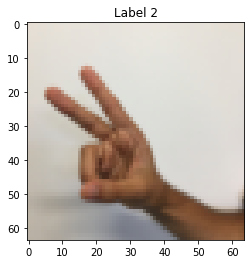

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

index = 6
plt.imshow(X_train[index])
plt.title('Label {}'.format(np.squeeze(y_train[:, index])))

plt.show()

**SHAPE OF DATA**

In [9]:
print("Train data:", X_train.shape)
print("Train labels:", y_train.shape)

print("Validation data:", X_val.shape)
print("Validation labels:", y_val.shape)

Train data: (1080, 64, 64, 3)
Train labels: (1, 1080)
Validation data: (120, 64, 64, 3)
Validation labels: (1, 120)


**PREPROCESS DATA**

We can see that data is composed of [m, H, W, C], which:


1.   m: Number of data
2.   H, W: Picture's height & width
3.   C: Number of channels 


In [10]:

X_train = X_train.reshape(-1, 3, 64, 64)
X_val = X_val.reshape(-1, 3, 64, 64)


#Normalise the data, divide by 255
X_train = X_train / 255.
X_val = X_val / 255.

**MAKE DATASET/DATALOADER**

In [11]:
import torch

X_train_tensor = torch.from_numpy(X_train.astype('float32'))
y_train_tensor = torch.from_numpy(np.squeeze(y_train).astype('int'))

X_val_tensor = torch.from_numpy(X_val.astype('float32'))
y_val_tensor = torch.from_numpy(np.squeeze(y_val).astype('int'))

#Make dataset from tensors

from torch.utils.data import TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

#Test dataset maker

print("Length of dataset:", len(train_dataset))

X_sample, y_sample = train_dataset[0]

Length of dataset: 1080


Now make a data loader

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

**BUILD MODEL**

In [13]:
#A basic CNN

import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32*13*13, 1024),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(1024, len(classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # flatten [m, C, H, W] -> [m, C*H*W]
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [14]:
model = CNN()
model = model.cuda() # use GPU
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=5408, out_features=1024, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=1024, out_features=6, bias=True)
)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

**TRAIN**

In [31]:
from torch.autograd import Variable

def fit(epochs):
    history = {
        'loss': [],
        'val_acc': []
    }
    
    def train(epoch):
        model.train()

        ITERATIONS = len(train_dataset) // BATCH_SIZE + 1
        for i, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            data, target = data.cuda(), target.cuda() # using GPU

            ## forward prop
            output = model(data)

            ## compute loss
            loss = criterion(output, target)

            ## backward prop and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Regularly check
            if (i+1) % 3 == 0:
                print("({}) [{}/{}] loss: {:.4f}".format(epoch+1, i+1, ITERATIONS,
                                                         loss.data))

        ## save training loss
        history['loss'].append(loss.data)
        
    def validate():
        model.eval()

        total = len(val_dataset)
        correct = 0
        for data, target in val_loader:
            data, target = Variable(data, volatile=True), Variable(target)
            data, target = data.cuda(), target.cuda() # use GPU

            # forward
            output = model(data)

            # get index of the max
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum() # check equality, then sum up

        val_acc = correct/total
        print("val_acc: {:.2f}".format(correct/total))
        
        # Save validation accuracy
        history['val_acc'].append(val_acc)        

    ## Start training, validate accuracy each epoch
    for epoch in range(0, epochs):
        train(epoch)
        validate()
    
    return history              

In [32]:
EPOCHS = 30
history = fit(EPOCHS)

(1) [3/9] loss: 1.2171
(1) [6/9] loss: 1.0339
(1) [9/9] loss: 1.0505
val_acc: 0.36
(2) [3/9] loss: 0.9927
(2) [6/9] loss: 0.8998
(2) [9/9] loss: 0.9002
val_acc: 0.23


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


(3) [3/9] loss: 0.8349
(3) [6/9] loss: 0.8653
(3) [9/9] loss: 0.8265
val_acc: 0.34
(4) [3/9] loss: 0.6163
(4) [6/9] loss: 0.7500
(4) [9/9] loss: 0.5630
val_acc: 0.39
(5) [3/9] loss: 0.6517
(5) [6/9] loss: 0.6348
(5) [9/9] loss: 0.6495
val_acc: 0.48
(6) [3/9] loss: 0.6522
(6) [6/9] loss: 0.5251
(6) [9/9] loss: 0.6350
val_acc: 0.43
(7) [3/9] loss: 0.6715
(7) [6/9] loss: 0.4033
(7) [9/9] loss: 0.3665
val_acc: 0.41
(8) [3/9] loss: 0.3801
(8) [6/9] loss: 0.4156
(8) [9/9] loss: 0.3125
val_acc: 0.44
(9) [3/9] loss: 0.3927
(9) [6/9] loss: 0.2861
(9) [9/9] loss: 0.3129
val_acc: 0.64
(10) [3/9] loss: 0.2452
(10) [6/9] loss: 0.2697
(10) [9/9] loss: 0.3142
val_acc: 0.59
(11) [3/9] loss: 0.1551
(11) [6/9] loss: 0.2078
(11) [9/9] loss: 0.1354
val_acc: 0.52
(12) [3/9] loss: 0.1298
(12) [6/9] loss: 0.1393
(12) [9/9] loss: 0.1926
val_acc: 0.58
(13) [3/9] loss: 0.1479
(13) [6/9] loss: 0.0983
(13) [9/9] loss: 0.1784
val_acc: 0.74
(14) [3/9] loss: 0.1063
(14) [6/9] loss: 0.0912
(14) [9/9] loss: 0.1934
val

**Visualize training process**

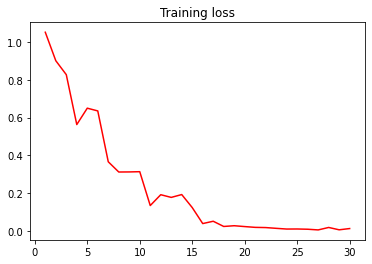

In [33]:
epochs = range(1, EPOCHS+1)

plt.plot(epochs, history['loss'], 'r')
plt.title('Training loss')
plt.show()

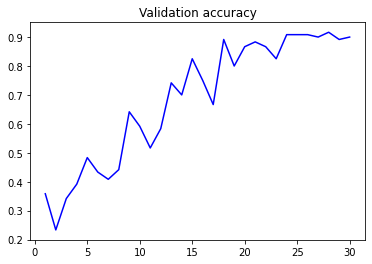

In [34]:
plt.plot(epochs, history['val_acc'], 'b')
plt.title('Validation accuracy')
plt.show()

**TEST**

In [36]:
def predict(X):
    """Arguments
        X: numpy image, shape (H, W, C)
    """
    # reshape
    shape = X.shape
    X = X.reshape((1, shape[2], shape[0], shape[1]))
    # normalize
    X = X / 255.
    
    X = torch.from_numpy(X.astype('float32'))
    X = Variable(X, volatile=True)
    
    # forward
    output = model.cpu()(X)

    # get index of the max
    _, index = output.data.max(1, keepdim=True)
    return classes[index[0][0]] 

Sample predict from validation data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


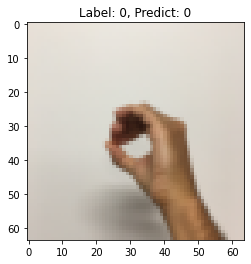

In [37]:
import random

_, _, X_val, y_val, classes = load_dataset()
index = random.randint(0, len(X_val))

pred = predict(X_val[index])

plt.imshow(X_val[index])
plt.title('Label: {}, Predict: {}'.format(np.squeeze(y_val[:,index]), pred))
plt.show()

**EXPORT**

In [38]:
import os

MODEL_DIR = 'model'
MODEL_PATH = os.path.join(MODEL_DIR, 'cnn.pth')

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
torch.save(model.state_dict(), MODEL_PATH)